In [2]:
import xarray as xr
import dask
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F


In [ ]:
from dask.distributed import Client
# quand tu es sur la page jupyterhub, il faut demander 20 CPU, check advanced SLURM options
client = Client()
client

#### Import data 
- to numpy
- remove depth -1

In [ ]:
data_TS = xr.open_mfdataset('/gpfsstore/rech/omr/uym68qx/nemo_output/DINO/Dinoffusion/1degree/restart*/DINO_10d_grid_T_3D.nc',
                            parallel=True)
data_TS

In [ ]:
data_SSH = xr.open_mfdataset('/gpfsstore/rech/omr/uym68qx/nemo_output/DINO/Dinoffusion/1degree/restart*/DINO_10d_grid_T_2D.nc',
                             parallel=True, decode_times=False)
data_SSH

In [ ]:
toce = data_TS.toce_inst.values
np.save('toce.npy', toce)
del toce

In [ ]:
soce = data_TS.soce_inst.values
np.save('soce.npy', soce)
del soce

In [ ]:
ssh = data_SSH.ssh_inst.values
np.save('ssh.npy', ssh)
del ssh

#### Processing 
- concatenate data
- remove edges
- mask
- standardize
- replace nan
- padding

In [3]:
def delTopBottom(data):
    """
        Top and bottom edges are empty. We can remove them.
    """
    return data [:,:,1:-1,:]

def replaceEdges(data,value=None):
    """
        Replace edges by a value. Default is nan
        data : batch, depth, x, y 
    """
    mask = np.zeros_like(data, dtype=bool)
    for i in [0,-1]:
        mask[:,:,:12,i] = True
        mask[:,:,47:,i] = True
    if value is None:
        data[mask] = np.nan
    else:
        data[mask] = value
    return data

def standardize_4D(data):
    """
        data : batch, depth, x, y 
    """
    # Get min, max value aming all elements for each column
    x_mean = np.nanmean(data, axis=(0,2,3), keepdims=True)
    x_std  = np.nanstd(data, axis=(0,2,3), keepdims=True)
    # Normalize with those min, max values leveraging broadcasting
    data = (data - x_mean)/ x_std
    return data, x_mean, x_std

def processData(data):
    """
        Apply functions above on T,S and SSH
        data : batch, depth, x, y 
    """
    
    #apply del north and south edges and apply nan mask
    data = delTopBottom(data)
    data = replaceEdges(data,None)
    data, x_mean, x_std = standardize_4D(data)
    #replace nan values by 0
    data = replaceEdges(data,-1)
    print("processed")
    return data,x_mean,x_std

In [4]:
# .npy files of T and S already have deptht -1 withdrawn
path = "/gpfswork/rech/omr/udu91zn/diffusionmodels"

toce, toce_mean, toce_std = processData(np.load(f'{path}/toce.npy'))
soce, soce_mean, soce_std = processData(np.load(f'{path}/soce.npy'))
ssh,  ssh_mean,  ssh_std  = processData(np.expand_dims(np.load(f'{path}/ssh.npy'),1))


dataset = np.concatenate((toce,soce,ssh), axis=1)
del toce, soce, ssh
mean    = np.concatenate((toce_mean,soce_mean,ssh_mean), axis=1)
del toce_mean, soce_mean, ssh_mean
std     = np.concatenate((toce_std,soce_std,ssh_std), axis=1)
del toce_std, soce_std, ssh_std
dataset_infos = {"mean":mean,"std":std}

processed
processed
processed


In [5]:
np.save('/gpfswork/rech/omr/uen17sn/DINO-Fusion/dataset_stand.npy', dataset)
np.savez('/gpfswork/rech/omr/uen17sn/DINO-Fusion/standardize_info', **dataset_infos)

ssh mean : -0.3273905


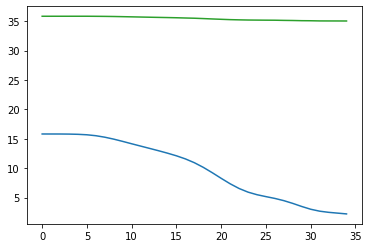

In [6]:
plt.plot(dataset_infos["mean"][0,:35,0,0],color="tab:blue")
plt.plot(dataset_infos["mean"][0,35:70,0,0],color="tab:green")
print("ssh mean :", dataset_infos["mean"][0,70,0,0])

ssh std : 0.77640617


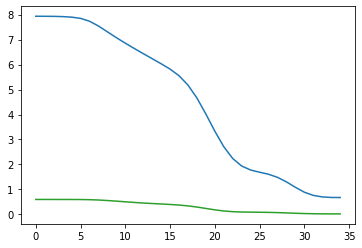

In [7]:
plt.plot(dataset_infos["std"][0,:35,0,0],color="tab:blue")
plt.plot(dataset_infos["std"][0,35:70,0,0],color="tab:green")
print("ssh std :", dataset_infos["std"][0,70,0,0])

In [8]:
del dataset, dataset_infos, mean, std


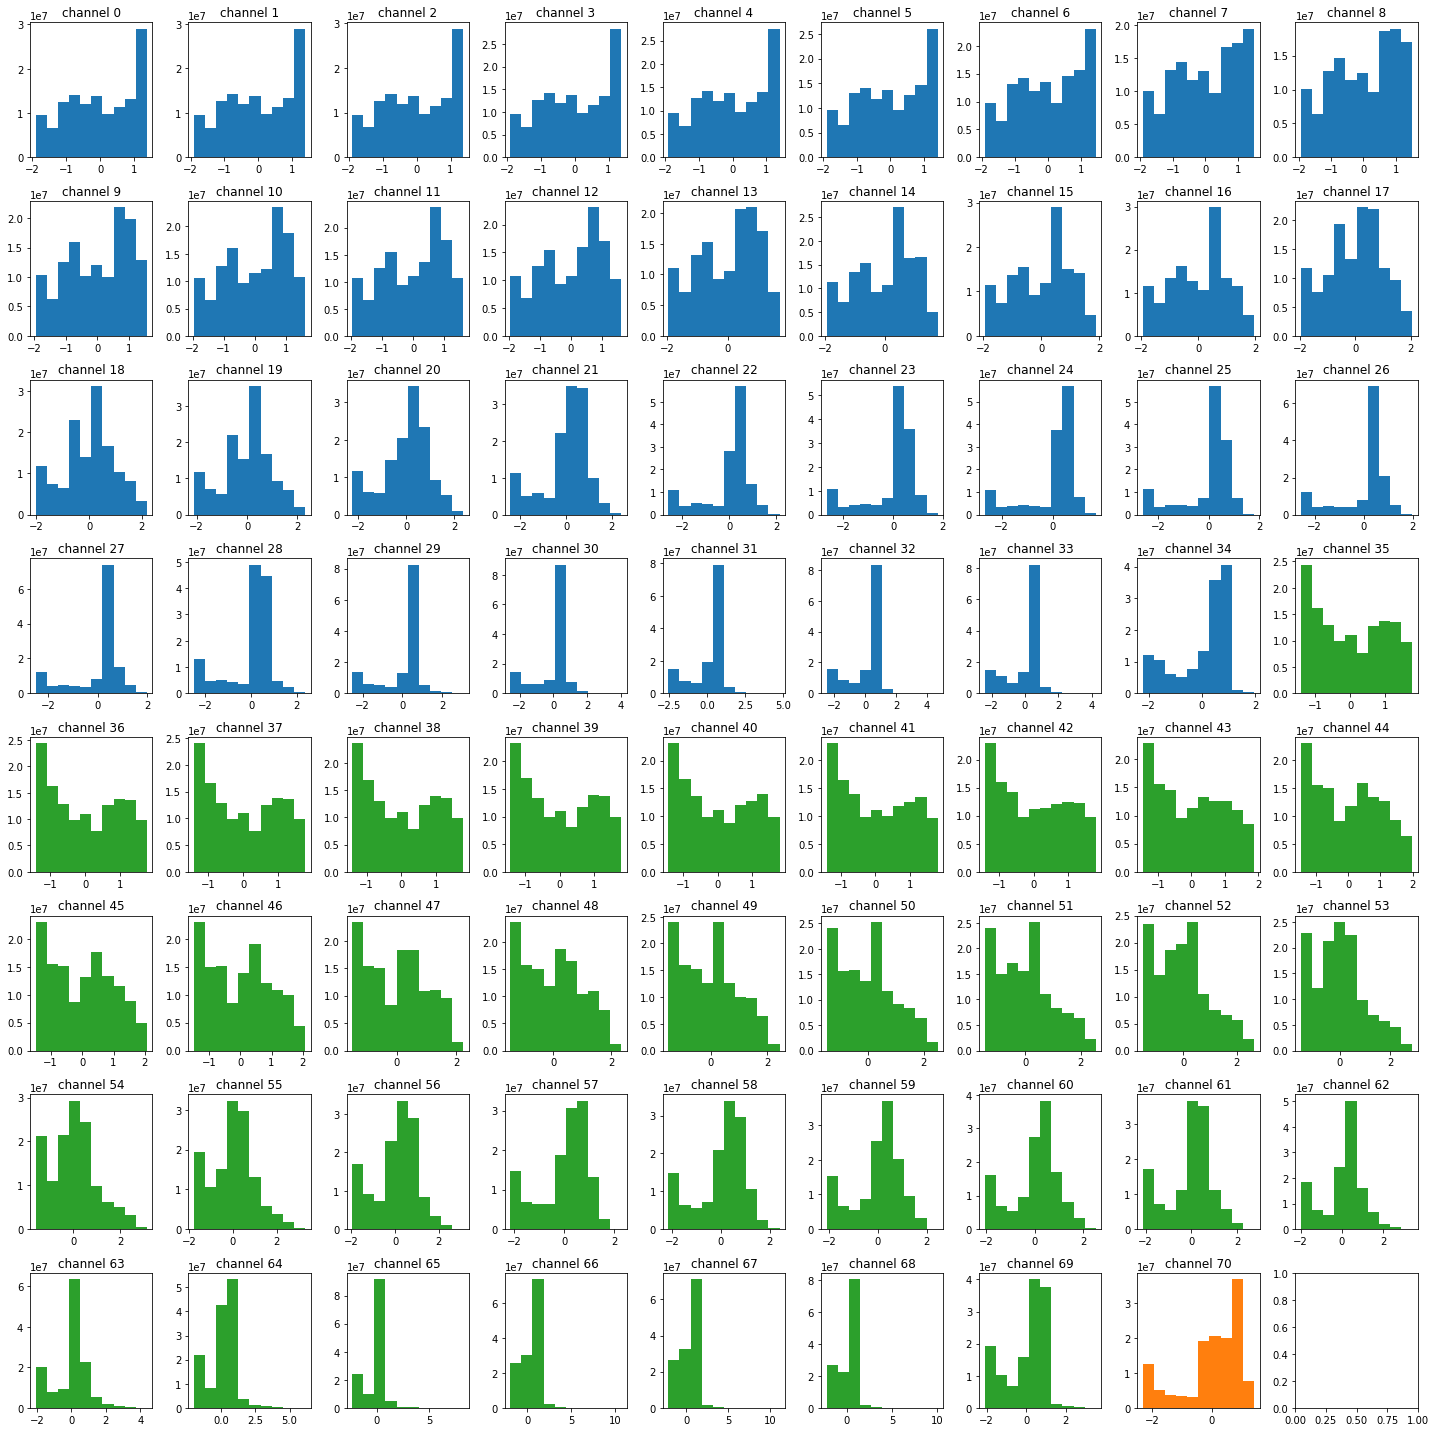

In [10]:
dataset = np.load('/gpfswork/rech/omr/uen17sn/DINO-Fusion/dataset_stand.npy')
data = np.transpose(dataset, (1, 0, 2, 3))
print(np.shape(dataset))
print(np.shape(data))

del dataset

data = data.reshape(71,-1)
print(np.shape(data))

fig, axs = plt.subplots(8, 9, figsize=(20, 20))
for i in range(8):
    for j in range(9):
        idx = i * 9 + j 
        if idx < np.shape(data)[0]:
            if idx<=35 : color = "tab:blue"
            if idx>=35 and idx<70 : color = "tab:green"
            if idx==70 : color = "tab:orange"
            axs[i, j].hist(data[idx],color=color)
            axs[i, j].set_title(f'channel {idx}')
plt.tight_layout()
plt.show()

In [11]:
del data

#### Batch processing 
- padding 
- Hide mask and padding for loss computation

In [81]:
dataset = np.load("/gpfswork/rech/omr/uen17sn/DINO-Fusion/dataset_stand.npy")
infos   = np.load('/gpfswork/rech/omr/uen17sn/DINO-Fusion/standardize_info.npz')

random  = np.random.choice(np.arange(len(dataset)), size=300, replace=False)
mini_data = dataset[random]
del dataset

In [82]:
np.save('/gpfswork/rech/omr/uen17sn/DINO-Fusion/minidata_stand.npy', mini_data)

In [73]:
def padData(batch,xpad,ypad,val):
    batch = F.pad(batch, (1, 1, xpad, ypad), "constant", val)
    return batch
    
def get_mask(batch):
    mask = torch.where(batch != -1, 1, 0).type(torch.float)
    return mask

def padAndMask(batch,xpad=2,ypad=1,val=-1):
    padded_batch = padData(batch,xpad,ypad,val)
    mask = get_mask(padded_batch)
    return padded_batch*mask


In [74]:
train_dataloader = torch.utils.data.DataLoader(mini_data, 16, shuffle=True)

torch.Size([16, 71, 200, 64])


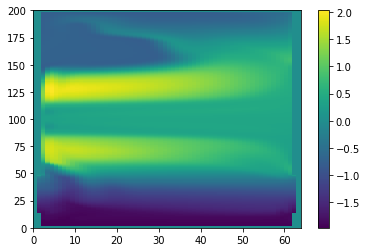

In [75]:
test = next(iter(train_dataloader))
test_pad = padAndMask(test,xpad=2,ypad=1,val=-1)
print(test_pad.shape)
plt.pcolor(test_pad[0,17])
plt.colorbar()

def delTopBottom(data):
    """
        Top and bottom edges are empty. We can remove them.
    """
    return data [:,:,1:-1,:]

def get_mask(data):
    """
        Get the edges mask of the DINO config
    """
    mask = np.zeros_like(data, dtype=bool)
    for i in [0,-1]:
        mask[:,:12,i] = True
        mask[:,47:,i] = True
    return mask

def replaceEdges(data,value=None):
    """
        Replace edges by a value. Default is nan
        data : batch, depth, x, y 
    """
    mask = get_mask(data)
    if value is None:
        data[mask] = np.nan
    else:
        data[mask] = value
    return data

def replaceEdgesByMean(data):
    """
        Replace edges by the current of the channel. Should be merged with replace Edges later.
    """
    mask   = get_mask(data)
    data   = np.transpose(data, (1, 0, 2, 3))
    x_mean = np.nanmean(data, axis=(1,2,3), keepdims=True)
    if len(data)==1 :
        data[0,mask] = x_mean.squeeze()
    else:
        for i in range(len(data)):
            data[i,mask] = x_mean.squeeze()[i]
    return np.transpose(data, (1, 0, 2, 3))


def standardization4D(data,**args):
    """
        Extract mean and std without standardization.
        Or
        Given a mean and std standardize the data
        data : batch, depth, x, y 
        **args : x_mean, x_std (1,N_Channels,1,1)
    """
    # Get min, max value aming all elements for each column
    if len(args)==0:
        x_mean = np.nanmean(data, axis=(0,2,3), keepdims=True)
        x_std  = np.nanstd(data,  axis=(0,2,3), keepdims=True)
        return x_mean, x_std
    else:
        x_mean  = args.get('x_mean')
        x_std   = args.get('x_std')
        # Normalize with those min, max values leveraging broadcasting
        data = (data - x_mean)/ x_std
        return data

def processData(data,x_mean,x_std):
    """
        Apply functions above on T,S and SSH
        data : batch, depth, x, y 
    """
    #apply del north and south edges and apply nan mask
    data = delTopBottom(data)
    data = replaceEdges(data,None)
    #mean, std = standardization4D(data,**args)
    data = standardization4D(data,x_mean=x_mean,x_std=x_std)
    #replace nan values by 0
    data = replaceEdges(data,0)
    #data = replaceEdgesByMean(data)
    print("processed")
    return data,x_mean,x_std

 .npy files of T and S already have deptht -1 withdrawn
path = "/gpfswork/rech/omr/udu91zn/diffusionmodels"

toce = np.load(f'{path}/toce.npy')
soce = np.load(f'{path}/soce.npy')
ssh  = np.expand_dims(np.load(f'{path}/ssh.npy'),1)

print(f"toce shape : {np.shape(toce)}")
print(f"soce shape : {np.shape(soce)}")
print(f"ssh shape  : {np.shape(ssh)}")

toce_mean, toce_std = standardization4D(toce)
soce_mean, soce_std = standardization4D(soce)
ssh_mean,  ssh_std  = standardization4D(ssh)

toce, toce_mean, toce_std = processData(toce,toce_mean,toce_std)
soce, soce_mean, soce_std = processData(soce,soce_mean,soce_std)
ssh,  ssh_mean,  ssh_std  = processData(ssh, ssh_mean, ssh_std)

dataset = np.concatenate((toce,soce,ssh), axis=1)
del toce, soce, ssh
mean = np.concatenate((toce_mean,soce_mean,ssh_mean), axis=1)
del toce_mean, soce_mean, ssh_mean
std = np.concatenate((toce_std,soce_std,ssh_std), axis=1)
del toce_std, soce_std, ssh_std
dataset_infos = {"mean":mean,"std":std}

print(f"dataset shape : {np.shape(dataset)}")
print(f"mean shape : {np.shape(dataset_infos['mean'])}")
print(f"std shape  : {np.shape(dataset_infos['std'])}")